In [1]:
pip install uszipcode

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import scipy.stats as stats
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

df = pd.read_csv('kc_house_data.csv')

## Changes Made To DataFrame

In [3]:
## dropped'id' because it's useless lol
## dropped 'date' because its too specific and replaced with a column that shows month categorically
## dropped'yr_built' because it doesn't tell us much BUT I also replaced with this column with how old the home is in 
## years
## dropped'yr_renovated' and made categorical as to whether it has been renovated or not
## dropped 'lat', feels useless
## dropped 'long', feels useless
## made zipcode into a string to make categorical
## made sqft_basement into floats (it was a string)
## created a total_sq_ft column combining basement sq fit with the rest of the house

In [4]:
def make_month(string):
    if string[:2] == '1/':
        return 'Jan'
    if string[:2] == '2/':
        return 'Feb'
    if string[:2] == '3/':
        return 'Mar'
    if string[:2] == '4/':
        return 'Apr'
    if string[:2] == '5/':
        return 'May'
    if string[:2] == '6/':
        return 'Jun'
    if string[:2] == '7/':
        return 'Jul'
    if string[:2] == '8/':
        return 'Aug'
    if string[:2] == '9/':
        return 'Sep'
    if string[:2] == '10':
        return 'Oct'
    if string[:2] == '11':
        return 'Nov'
    if string[:2] == '12':
        return 'Dec'

In [5]:
df_alt = df.drop(['id', 'date', 'yr_built', 'yr_renovated', 'lat', 'long'], axis = 1)
month_list = []
sqft_basement_list = []
yr_renovated = []
for date in df['date'].values:
    month_list.append(make_month(date))
for num in df['sqft_basement'].values:
    if num == '?':
        sqft_basement_list.append(np.nan)
    else:
        sqft_basement_list.append(float(num))
for data in df['yr_renovated'].values:
    if data == 0:
        yr_renovated.append(0)
    elif data == np.nan:
        yr_renovated.append(np.nan)
    else:
        yr_renovated.append(1)
df['month'] = month_list
df_alt['month'] = month_list
df['sqft_basement'] = sqft_basement_list
df_alt['sqft_basement'] = sqft_basement_list
df['renovated'] = yr_renovated
df_alt['renovated'] = yr_renovated
df_alt['zipcode'] = df_alt['zipcode'].apply(str)
df['age_of_house'] = 2021 - df['yr_built']
df_alt['age_of_house'] = 2021 - df['yr_built']
df_alt.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,month,renovated,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,98178,1340,5650,Oct,0,66
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,98125,1690,7639,Dec,1,70
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,98028,2720,8062,Feb,1,88
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,98136,1360,5000,Dec,0,56
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,98074,1800,7503,Feb,0,34


In [6]:
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

def zip_lookup(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

df_alt['City'] = df_alt['zipcode'].apply(zip_lookup)

In [7]:
df_alt_no_outliers = df_alt[(df_alt.bedrooms <= 5) & (df_alt.bedrooms >=2) & (df_alt.sqft_living <= 3000) & 
                            ((df_alt.floors == 1) | (df_alt.floors ==2))]

df_alt_no_outliers_seattle = df_alt_no_outliers[df_alt_no_outliers['City'] == 'Seattle']
df_alt_no_outliers_seattle

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,month,renovated,age_of_house,City
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,98178,1340,5650,Oct,0,66,Seattle
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,98125,1690,7639,Dec,1,70,Seattle
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,98136,1360,5000,Dec,0,56,Seattle
7,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,1060,0.0,98198,1650,9711,Jan,0,58,Seattle
8,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,1050,730.0,98146,1780,8113,Apr,0,61,Seattle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,572000.0,4,2.75,2770,3852,2.0,0.0,0.0,3,8,2770,0.0,98178,1810,5641,Oct,1,7,Seattle
21591,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,1180,130.0,98116,1330,1265,Feb,0,13,Seattle
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,98146,1830,7200,Feb,0,7,Seattle
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,98144,1020,2007,Jun,0,12,Seattle


In [8]:
df_alt_no_outliers_seattle['price_adjusted_M'] = df_alt_no_outliers_seattle['price'] / 1000000
df_alt_no_outliers_seattle

std = df_alt_no_outliers_seattle['price_adjusted_M'].std()
mean = df_alt_no_outliers_seattle['price_adjusted_M'].mean()

lower_bound = mean - std
upper_bound = mean + std

df_alt_no_outliers_seattle = df_alt_no_outliers_seattle[(df_alt_no_outliers_seattle['price_adjusted_M'] >= lower_bound) & 
        (df_alt_no_outliers_seattle['price_adjusted_M'] <= upper_bound)]
df_alt_no_outliers_seattle

<ipython-input-8-173a3cba8fb3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alt_no_outliers_seattle['price_adjusted_M'] = df_alt_no_outliers_seattle['price'] / 1000000


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,month,renovated,age_of_house,City,price_adjusted_M
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,98125,1690,7639,Dec,1,70,Seattle,0.538000
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,98136,1360,5000,Dec,0,56,Seattle,0.604000
7,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,3,7,1060,0.0,98198,1650,9711,Jan,0,58,Seattle,0.291850
11,468000.0,2,1.00,1160,6000,1.0,0.0,0.0,4,7,860,300.0,98115,1330,6000,May,0,79,Seattle,0.468000
15,650000.0,4,3.00,2950,5000,2.0,0.0,3.0,3,9,1980,970.0,98126,2140,4000,Jan,0,42,Seattle,0.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,572000.0,4,2.75,2770,3852,2.0,0.0,0.0,3,8,2770,0.0,98178,1810,5641,Oct,1,7,Seattle,0.572000
21591,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,1180,130.0,98116,1330,1265,Feb,0,13,Seattle,0.475000
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,98146,1830,7200,Feb,0,7,Seattle,0.400000
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,98144,1020,2007,Jun,0,12,Seattle,0.402101


In [9]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,age_of_house
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,...,-0.004548,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.007227,-0.021617
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,...,0.325008,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845,0.050430,-0.053953
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,...,0.302683,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.003605,-0.155670
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,...,0.282693,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303,0.008587,-0.507173
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,...,0.434576,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342,0.013977,-0.318152
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,...,0.015533,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204,-0.006607,-0.052946
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,...,-0.245144,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722,-0.004810,-0.489193
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,...,0.090200,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002,0.033944,0.026079
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,...,0.276521,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332,0.044867,0.054564
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,...,0.170972,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126,-0.027056,0.361592


In [10]:
df_c = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_c['pairs'] = list(zip(df_c.level_0, df_c.level_1))
df_c.set_index(['pairs'], inplace = True)
df_c.drop(columns=['level_1', 'level_0'], inplace = True)
df_c.columns = ['cc']
df_c.drop_duplicates(inplace=True)
df_c[(df_c.cc>.75) & (df_c.cc <1)]


,cc
pairs,
"(renovated, yr_renovated)",0.999968
"(sqft_above, sqft_living)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [11]:
x = df['price']
y = df['sqft_above']
z = df['sqft_living']
print(np.corrcoef(x, y))
print(np.corrcoef(x, z)) #We should drop sqft_above

[[1.         0.60536794]
 [0.60536794 1.        ]]
[[1.        0.7019173]
 [0.7019173 1.       ]]


In [12]:
y1 = df['grade']
print(np.corrcoef(x, y1))
print(np.corrcoef(x, z)) #We should drop grade

[[1.         0.66795077]
 [0.66795077 1.        ]]
[[1.        0.7019173]
 [0.7019173 1.       ]]


In [13]:
y2 = df['sqft_living15']
print(np.corrcoef(x, y2))
print(np.corrcoef(x, z)) #We should drop sqft_living15

[[1.        0.5852412]
 [0.5852412 1.       ]]
[[1.        0.7019173]
 [0.7019173 1.       ]]


In [14]:
print(np.corrcoef(x, y1))
print(np.corrcoef(x, y))#We should drop sqft_above

[[1.         0.66795077]
 [0.66795077 1.        ]]
[[1.         0.60536794]
 [0.60536794 1.        ]]


In [15]:
y3 = df['bathrooms']
print(np.corrcoef(x, y3))
print(np.corrcoef(x, z))#We should drop bathrooms

[[1.         0.52590562]
 [0.52590562 1.        ]]
[[1.        0.7019173]
 [0.7019173 1.       ]]


In [16]:
df_alt['bedrooms']

0        3
1        3
2        2
3        4
4        3
        ..
21592    3
21593    4
21594    2
21595    3
21596    2
Name: bedrooms, Length: 21597, dtype: int64

In [17]:
df_damn = df_alt.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_damn['pairs'] = list(zip(df_damn.level_0, df_damn.level_1))
df_damn.set_index(['pairs'], inplace = True)
df_damn.drop(columns=['level_1', 'level_0'], inplace = True)
df_damn.columns = ['cc']
df_damn.drop_duplicates(inplace=True)
df_damn[(df_damn.cc>.75) & (df_damn.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(bathrooms, sqft_living)",0.755758


In [18]:
#df_zdict = {}
#df_exp = df_alt.dropna()
#for col in list(df_alt[z_exp].columns):
    #df_zdict[col] = zscore(df_exp[col])
#df_z = pd.DataFrame(df_zdict)
#df_z.head()
#z = list(df_z.columns[1:-1])
#zx = ['sqft_living', 'age_of_house']
#z_join = '+'.join(z)
#zx_join = '+'.join(zx)
#df_z['sqft_lot15'].value_counts()

In [19]:
#predictors = '+'.join(list(df_alt.columns[1:]))
#cont_var_pred = '+'.join(cont_var[1:])
#cont_var_multi = '+'.join(cont_var_edit)
#cont_var_pj = '+'.join(cont_var_p)
#cont_var_pj

In [20]:
#cont_var = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_of_house', 'total_sq_ft']
#cont_var_edit = ['sqft_living', 'sqft_lot','sqft_basement', 'sqft_lot15','age_of_house', 'total_sq_ft']
#cont_var_p = ['sqft_living','sqft_basement', 'sqft_lot15','age_of_house', 'total_sq_ft']
#z_exp = ['price','sqft_living','sqft_basement', 'sqft_lot15','age_of_house', 'total_sq_ft']
#categorical_var = ['waterfront', 'view', 'condition', 'floors', 'bedrooms']
#categorical_var_cont = ['bathrooms', 'grade', 'zipcode', 'renovated']

In [21]:
#try_pred = 'C(bedrooms)+sqft_living+sqft_lot+C(floors)+C(waterfront)+C(view)+C(condition)+sqft_basement+sqft_lot15+C(renovated)+age_of_house+total_sq_ft'
#time_pred = 'C(bedrooms)+sqft_living+sqft_lot+C(floors)+C(waterfront)+C(view)+C(condition)+sqft_basement+sqft_lot15+C(renovated)+age_of_house+total_sq_ft + C(month) + C(zipcode)'

In [22]:
#lr = ols(formula = 'price ~' + z_join, data = df_z).fit()
#lr.summary()

In [23]:
df_exp = df_alt_no_outliers_seattle[['price_adjusted_M', 'condition']]

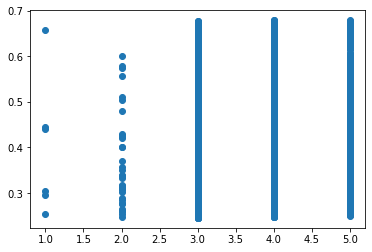

In [24]:
#plt.hist(df_exp['price_adjusted_M'], edgecolor = 'black', bins = 20)
plt.scatter(df_exp['condition'], df_exp['price_adjusted_M'])
#plt.plot('r--')

In [25]:
df_exp['condition']
con_dummies = pd.get_dummies(df_exp['condition'], prefix='con', drop_first=True)
df_evo = pd.concat([df_exp['price'], con_dummies], axis=1)
df_evo.head()

KeyError: 'price'

In [ ]:
#plt.scatter(df_exp['condition'], df_exp['price'])
#plt.show

In [ ]:
lr2 = smf.ols(formula = 'price_adjusted_M ~ condition', data = df_exp[df_exp['condition'] != 1]).fit()
lr2.summary()


BUILDING CONDITION
    	Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

In [ ]:
a = df_exp[df_exp['condition'] == 1]['price_adjusted_M']
b = df_exp[df_exp['condition'] == 2]['price_adjusted_M']
c = df_exp[df_exp['condition'] == 3]['price_adjusted_M']
d = df_exp[df_exp['condition'] == 4]['price_adjusted_M']
e = df_exp[df_exp['condition'] == 5]['price_adjusted_M']
f = a, b, c, d, e

In [ ]:
print(f"""From condition 1 to condition 2, you actually see a loss ({round(((b - a)/a) * 100, 2)}%) in 
average selling price so this is not worth it BUT improving 1 to 3 shows a {round(((c - a)/a) * 100, 2)}% 
increase, 1 - 4 shows a {round(((d - a)/a) * 100, 2)}% increase, and 1-5 shows a
{round(((e - a)/a) * 100, 2)}% increase""")

In [ ]:
print(f"""From condition 2 to condition 3 shows a {round(((c - b)/b) * 100, 2)}% 
increase, 2 - 4 shows a {round(((d - b)/b) * 100, 2)}% increase, and 2 - 5 shows a
{round(((e - b)/b) * 100, 2)}% increase""")

In [ ]:
print(f"""From condition 3 to condition 4 shows a {round(((d - c)/c) * 100, 2)}% 
increase and 3 - 5 shows a {round(((e - c)/c) * 100, 2)}% increase""")

In [ ]:
print(f"""From condition 4 to condition 5 shows a {round(((e - d)/d) * 100, 2)}% increase""")

### Assuming that improving conditions aren't worth it unless the sale price bumps up more then 10%, the only conditions that are worth it are going from condition 1 to 5 and condition 2 to anywhere above 2

In [ ]:
plt.plot(f)

In [ ]:
box_dict = {}
for i in range(1, 6):
    box_dict[i] = df_exp.loc[df['condition'] == i]['price_adjusted_M'].values
fig, ax = plt.subplots()
ax.boxplot(box_dict.values())
ax.set_xticklabels(box_dict.keys())

In [ ]:
df_exp[df_exp['condition'] == 1]['price_adjusted_M']
for i in range(1, 5):
    for j in range(1, 6):
        if stats.ttest_ind(df_exp[df_exp['condition'] == i]['price_adjusted_M'], df_exp[df_exp['condition'] == j]['price_adjusted_M'])[1] <= 0.05:
            print(f"Groups {i} and {j} are statistically significantly different")

In [ ]:
stats.ttest_ind(df_exp[df_exp['condition'] == 1]['price_adjusted_M'], df_exp[df_exp['condition'] == 2]['price_adjusted_M'])
